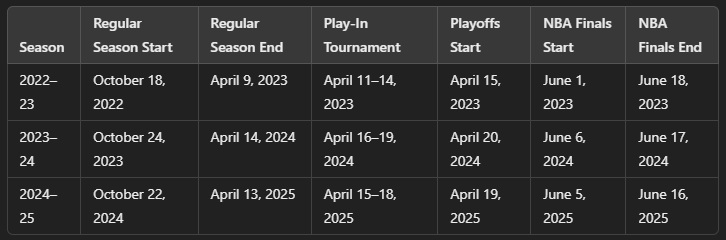

In [56]:
from datetime import datetime
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 400)

def load_and_filter(
    file_path: str, time_context: Optional[tuple] = None, time_column: str = "game_date"
):
    """
    Load a CSV file and filter dfs based on a time context.

    Args:
        file_path (str): Path to the CSV file.
        time_context (tuple): A tuple containing start and end time-like objects. Can be strings, datetime, or Pandas Timestamp.
        time_column (str): The column name containing time data.

    Returns:
        pd.DataFrame: Filtered DataFrame based on the time context.
    """
    try:
        df = pd.read_csv(file_path)
        if time_column not in df.columns:
            raise KeyError(f"Time column '{time_column}' not found in the DataFrame.")

        df[time_column] = pd.to_datetime(df[time_column], errors="coerce")
        df = df.dropna(subset=[time_column])

        if time_context:
            if not isinstance(time_context, tuple) or len(time_context) != 2:
                raise ValueError(
                    "time_context must be a tuple with two elements (start_time, end_time)."
                )

            # Parse the time_context into datetime objects
            start_time, end_time = time_context

            if start_time is not None:
                start_time = pd.to_datetime(start_time, errors="coerce")
                if start_time is pd.NaT:
                    raise ValueError(f"Invalid start_time: {time_context[0]}")
                df = df[df[time_column] >= start_time]

            if end_time is not None:
                end_time = pd.to_datetime(end_time, errors="coerce")
                if end_time is pd.NaT:
                    raise ValueError(f"Invalid end_time: {time_context[1]}")
                df = df[df[time_column] <= end_time]

        return df

    except Exception as e:
        raise RuntimeError(
            f"An error occurred while loading and filtering the CSV: {e}"
        )


fantasy_point_weights = {
    "points": 1,
    "reboundsTotal": 1.25,
    "assists": 1.5,
    "steals": 2,
    "blocks": 2,
    "turnovers": -0.5,
    "double-double": 1.5,
    "triple-double": 3,
}


def compute_fantasy_points(df):
    # Base fantasy points (excluding bonuses)
    base_points = sum(
        [
            df[col_name] * weight
            for col_name, weight in fantasy_point_weights.items()
            if col_name not in ["double-double", "triple-double"]
        ]
    )

    # Count the number of stats >= 10 for double-double/triple-double logic
    stats = ["points", "reboundsTotal", "assists", "steals", "blocks"]
    double_digit_count = sum(df[stat] >= 10 for stat in stats)

    # Calculate double-double and triple-double bonuses
    double_double_bonus = (double_digit_count >= 2) * fantasy_point_weights[
        "double-double"
    ]
    triple_double_bonus = (double_digit_count >= 3) * fantasy_point_weights[
        "triple-double"
    ]

    df["fantasyPoints"] = base_points + double_double_bonus + triple_double_bonus
    return base_points + double_double_bonus + triple_double_bonus


def preprocess_box_scores(df: pd.DataFrame):
    def convert_to_decimal_minutes(value):
        if pd.isna(value):
            return 0
        try:
            minutes, seconds = map(int, value.split(":"))
            return minutes + seconds / 60
        except ValueError:
            # Handle any unexpected format
            return 0

    df = df.sort_values(["game_date", "gameId", "personId"])

    # Convert minutes from mm::ss to decimal format
    df = df.assign(minutes=df["minutes"].apply(convert_to_decimal_minutes))
    # Compute fantasy points
    df = df.assign(fantasyPoints=compute_fantasy_points(df))
    
    return df.reset_index()


# r1.columns

In [74]:
%%time

ctx = ("20230101", "20240501")
r1 = load_and_filter("../data/raw/regular_season_box_scores_2010_2024_part_1.csv", ctx)
r2 = load_and_filter("../data/raw/regular_season_box_scores_2010_2024_part_2.csv", ctx)
r3 = load_and_filter("../data/raw/regular_season_box_scores_2010_2024_part_3.csv", ctx)


# columns = [
#     "game_date",
#     "gameId",
#     "matchup",
#     "teamId",
#     "teamName",
#     "personId",
#     "personName",
#     "position",
#     "comment",
#     "minutes",
#     "fieldGoalsMade",
#     "fieldGoalsAttempted",
#     "fieldGoalsPercentage",
#     "threePointersMade",
#     "threePointersAttempted",
#     "threePointersPercentage",
#     "freeThrowsMade",
#     "freeThrowsAttempted",
#     "freeThrowsPercentage",
#     "reboundsOffensive",
#     "reboundsDefensive",
#     "reboundsTotal",
#     "assists",
#     "steals",
#     "blocks",
#     "turnovers",
#     "foulsPersonal",
#     "points",
#     "plusMinusPoints",
# ]

cols = [
    "game_date",
    "gameId",
    "matchup",
    'teamId',
    "teamName",
    "personId",
    "personName",
    "minutes",
    "points",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "plusMinusPoints",
    'fantasyPoints',
    'projectedFantasyPoints',
    'outperformed'
]


df = pd.concat([r1, r2, r3])
df = preprocess_box_scores(df)

# Compute projected fantasy points
# df = df.assign(
#     projectedFantasyPoints=df.groupby("personId")["fantasyPoints"]
#     .rolling(window=5, min_periods=1)
#     .mean()
#     .reset_index(level=0, drop=True)
#     .shift(1)
#     .reset_index(drop=True)
# )

df = df.assign(
    projectedFantasyPoints=df.groupby('personId')['fantasyPoints']  # Group by personId
    .apply(lambda x: x.rolling(window=5, min_periods=1).mean().shift(1))  # Rolling mean and shift within group
    .reset_index(level=0, drop=True)  # Flatten the inde
)
df = df.assign(outperformed=df["fantasyPoints"] > df["projectedFantasyPoints"])
df = df[cols].reset_index()

game_date_range = (str(df["game_date"].min()), str(df["game_date"].max()))
print(
    f"Time Range: {game_date_range} \nGames: {len(df['gameId'].unique())} \nTeams: {len(df['teamId'].unique())} \nPlayers: {len(df['personId'].unique())}"
)
print("-----" * 5)

Time Range: ('2023-01-01 00:00:00', '2024-04-14 00:00:00') 
Games: 1914 
Teams: 30 
Players: 664
-------------------------
CPU times: total: 1.86 s
Wall time: 1.99 s


In [77]:
df['outperformed'].value_counts()

outperformed
False    28839
True     21113
Name: count, dtype: int64

In [75]:
df

,index,game_date,gameId,matchup,teamId,teamName,personId,personName,minutes,points,reboundsTotal,assists,steals,blocks,turnovers,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed
0,0,2023-01-01,22200547,SAC @ MEM,1610612758,Kings,203084,Harrison Barnes,28.533333,16,5,1,1,0,2,-2,24.75,NaN,False
1,1,2023-01-01,22200547,SAC @ MEM,1610612758,Kings,203458,Alex Len,1.433333,0,0,1,0,0,1,2,1.00,NaN,False
2,2,2023-01-01,22200547,MEM vs. SAC,1610612763,Grizzlies,203500,Steven Adams,34.483333,11,23,3,1,2,4,4,49.75,NaN,False
3,3,2023-01-01,22200547,SAC @ MEM,1610612758,Kings,203521,Matthew Dellavedova,1.433333,0,0,0,0,0,0,2,0.00,NaN,False
4,4,2023-01-01,22200547,MEM vs. SAC,1610612763,Grizzlies,1626145,Tyus Jones,32.316667,18,6,8,1,0,0,14,39.50,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49947,49947,2024-04-14,22301200,POR @ SAC,1610612757,Trail Blazers,1631386,Taze Moore,30.150000,12,8,4,1,0,2,-27,29.00,1.00,True
49948,49948,2024-04-14,22301200,POR @ SAC,1610612757,Trail Blazers,1641712,Rayan Rupert,40.266667,11,6,5,0,0,2,-25,25.00,15.80,True
49949,49949,2024-04-14,22301200,SAC vs. POR,1610612758,Kings,1641732,Colby Jones,4.283333,8,1,1,0,1,0,1,12.75,7.70,True
49950,49950,2024-04-14,22301200,SAC vs. POR,1610612758,Kings,1641771,Jalen Slawson,3.633333,2,0,0,0,0,0,5,2.00,0.00,True


In [76]:
pd.set_option("display.max_rows", 400)
pdf = df[df.personId.isin([1641771])].sort_values(['game_date', 'gameId', 'personId'])#.head(20)
# pdf = df[df.personId.isin([2544, 203084, 203458, 203500])].sort_values(['game_date', 'gameId', 'personId'])#.head(20)
pdf.sort_values(['personId', 'game_date', 'gameId'])


,index,game_date,gameId,matchup,teamId,teamName,personId,personName,minutes,points,reboundsTotal,assists,steals,blocks,turnovers,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed
18336,18336,2023-10-27,22300087,SAC vs. GSW,1610612758,Kings,1641771,Jalen Slawson,0.000000,0,0,0,0,0,0,0,0.00,NaN,False
18697,18697,2023-10-29,22300100,SAC vs. LAL,1610612758,Kings,1641771,Jalen Slawson,0.000000,0,0,0,0,0,0,0,0.00,0.00,False
19407,19407,2023-11-01,22300126,SAC @ GSW,1610612758,Kings,1641771,Jalen Slawson,0.000000,0,0,0,0,0,0,0,0.00,0.00,False
22018,22018,2023-11-15,22300198,SAC @ LAL,1610612758,Kings,1641771,Jalen Slawson,0.200000,0,0,0,0,0,0,0,0.00,0.00,False
22257,22257,2023-11-17,22300032,SAC @ SAS,1610612758,Kings,1641771,Jalen Slawson,0.000000,0,0,0,0,0,0,0,0.00,0.00,False
22678,22678,2023-11-19,22300212,SAC @ DAL,1610612758,Kings,1641771,Jalen Slawson,3.933333,0,1,0,0,0,0,-3,1.25,0.00,True
22944,22944,2023-11-20,22300222,SAC @ NOP,1610612758,Kings,1641771,Jalen Slawson,12.000000,4,3,2,0,1,1,-5,12.25,0.25,True
23360,23360,2023-11-22,22300233,SAC @ NOP,1610612758,Kings,1641771,Jalen Slawson,0.000000,0,0,0,0,0,0,0,0.00,2.70,False
23706,23706,2023-11-24,22300050,SAC @ MIN,1610612758,Kings,1641771,Jalen Slawson,0.000000,0,0,0,0,0,0,0,0.00,2.70,False
24470,24470,2023-11-28,22300060,SAC vs. GSW,1610612758,Kings,1641771,Jalen Slawson,0.000000,0,0,0,0,0,0,0,0.00,2.70,False


In [128]:
pdf.groupby("personId")["fantasyPoints"].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True).shift(1)

77270        NaN
77128    24.7500
77404    29.6250
77170    29.7500
77357    28.3125
77407    29.1000
77122    28.2500
77423    29.7000
77258    30.9000
77092    32.0000
77272    28.6500
77208    31.2500
77484    28.2000
77218    23.6500
77269    21.6000
77109    22.4000
77259    20.5000
77229    21.9500
77136    21.7000
77220    21.8000
Name: fantasyPoints, dtype: float64

In [91]:
df.groupby("personId")["fantasyPoints"].rolling(
    window=5, min_periods=1
).mean().reset_index(level=0, drop=True)

43352     67.750000
43302     57.750000
43408     57.666667
43215     58.625000
43512     59.700000
            ...    
113010     5.916667
113013     9.250000
113012    13.300000
113008    11.550000
113011    13.350000
Name: fantasyPoints, Length: 49952, dtype: float64

In [100]:
d = (
    df.groupby("personId")["fantasyPoints"]
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
    .shift(-1)
    .reset_index(drop=True)
)
d

0        57.750000
1        57.666667
2        58.625000
3        59.700000
4        60.450000
           ...    
49947     9.250000
49948    13.300000
49949    11.550000
49950    13.350000
49951          NaN
Name: fantasyPoints, Length: 49952, dtype: float64

In [98]:
type(d)

pandas.core.series.Series

In [96]:
len(df)

49952

outperformed
False    42600
True      7352
Name: count, dtype: int64

In [104]:
pdf = df[df.personId == 2544]

In [105]:
pdf.dtypes

game_date                  datetime64[ns]
gameId                              int64
matchup                            object
teamId                              int64
teamName                           object
personId                            int64
personName                         object
position                           object
comment                            object
minutes                           float64
fieldGoalsMade                      int64
fieldGoalsAttempted                 int64
fieldGoalsPercentage              float64
threePointersMade                   int64
threePointersAttempted              int64
threePointersPercentage           float64
freeThrowsMade                      int64
freeThrowsAttempted                 int64
freeThrowsPercentage              float64
reboundsOffensive                   int64
reboundsDefensive                   int64
reboundsTotal                       int64
assists                             int64
steals                            

In [110]:
df[cols]

,game_date,gameId,matchup,teamName,personId,personName,points,reboundsTotal,assists,steals,blocks,turnovers,fantasyPoints,projectedFantasyPoints,outperformed
77270,2023-01-01,22200547,SAC @ MEM,Kings,203084,Harrison Barnes,16,5,1,1,0,2,24.75,NaN,False
78056,2023-01-01,22200547,SAC @ MEM,Kings,203458,Alex Len,0,0,1,0,0,1,1.00,NaN,False
63183,2023-01-01,22200547,MEM vs. SAC,Grizzlies,203500,Steven Adams,11,23,3,1,2,4,49.75,NaN,False
78631,2023-01-01,22200547,SAC @ MEM,Kings,203521,Matthew Dellavedova,0,0,0,0,0,0,0.00,NaN,False
64246,2023-01-01,22200547,MEM vs. SAC,Grizzlies,1626145,Tyus Jones,18,6,8,1,0,0,39.50,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,2024-04-14,22301200,POR @ SAC,Trail Blazers,1631386,Taze Moore,12,8,4,1,0,2,29.00,NaN,False
70014,2024-04-14,22301200,POR @ SAC,Trail Blazers,1641712,Rayan Rupert,11,6,5,0,0,2,25.00,NaN,False
84612,2024-04-14,22301200,SAC vs. POR,Kings,1641732,Colby Jones,8,1,1,0,1,0,12.75,NaN,False
84632,2024-04-14,22301200,SAC vs. POR,Kings,1641771,Jalen Slawson,2,0,0,0,0,0,2.00,NaN,False


In [111]:
df[df.personId == 203084]

,game_date,gameId,matchup,teamId,teamName,personId,personName,position,comment,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed
77270,2023-01-01,22200547,SAC @ MEM,1610612758,Kings,203084,Harrison Barnes,F,NaN,28.533333,4,12,0.333,4,9,0.444,4,4,1.000,0,5,5,1,1,0,2,0,16,-2,24.75,NaN,False
77128,2023-01-03,22200563,SAC @ UTA,1610612758,Kings,203084,Harrison Barnes,F,NaN,37.100000,7,13,0.538,3,7,0.429,2,2,1.000,1,7,8,2,2,0,3,2,19,4,34.50,NaN,False
77404,2023-01-04,22200575,SAC vs. ATL,1610612758,Kings,203084,Harrison Barnes,F,NaN,36.883333,7,15,0.467,2,7,0.286,6,6,1.000,2,2,4,1,1,0,1,1,22,4,30.00,NaN,False
77170,2023-01-07,22200595,SAC vs. LAL,1610612758,Kings,203084,Harrison Barnes,F,NaN,36.500000,4,9,0.444,2,5,0.400,8,10,0.800,2,0,2,1,0,1,0,1,18,-6,24.00,NaN,False
77357,2023-01-09,22200610,SAC vs. ORL,1610612758,Kings,203084,Harrison Barnes,F,NaN,30.466667,11,13,0.846,6,7,0.857,2,3,0.667,0,1,1,1,0,0,1,1,30,17,32.25,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77374,2024-04-07,22301141,SAC @ BKN,1610612758,Kings,203084,Harrison Barnes,F,NaN,11.250000,1,4,0.250,0,2,0.000,0,0,0.000,0,0,0,0,0,0,0,1,2,-15,2.00,NaN,False
77125,2024-04-09,22301153,SAC @ OKC,1610612758,Kings,203084,Harrison Barnes,F,NaN,26.716667,1,8,0.125,0,4,0.000,8,10,0.800,2,4,6,0,1,0,1,1,10,-3,19.00,NaN,False
77098,2024-04-11,22301170,SAC vs. NOP,1610612758,Kings,203084,Harrison Barnes,F,NaN,32.483333,9,15,0.600,2,6,0.333,2,2,1.000,1,4,5,4,1,0,0,2,22,-18,36.25,NaN,False
77471,2024-04-12,22301185,SAC vs. PHX,1610612758,Kings,203084,Harrison Barnes,F,NaN,41.383333,3,10,0.300,1,4,0.250,5,5,1.000,2,4,6,3,1,1,0,0,12,7,28.00,NaN,False


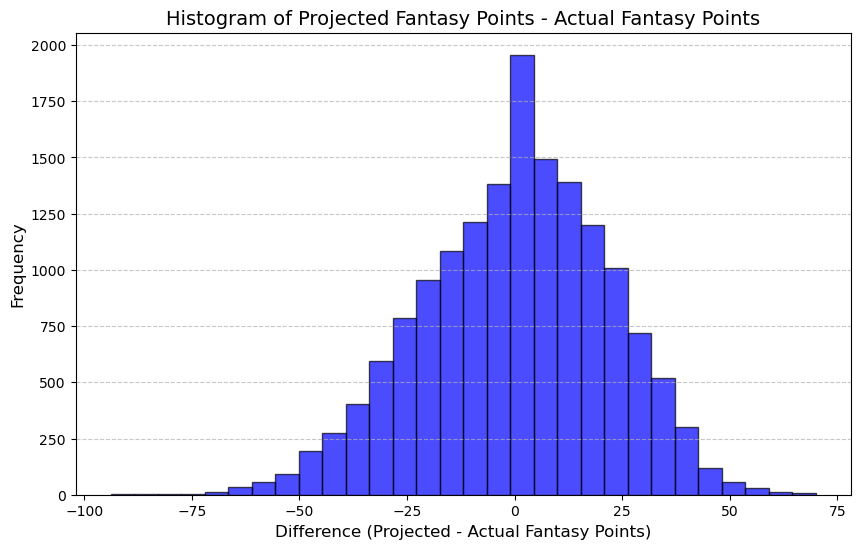

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(
    df["projectedFantasyPoints"] - df["fantasyPoints"],
    bins=30,
    alpha=0.7,
    color="blue",
    edgecolor="black",
)
plt.title("Histogram of Projected Fantasy Points - Actual Fantasy Points", fontsize=14)
plt.xlabel("Difference (Projected - Actual Fantasy Points)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [108]:
df[df.personName == "LeBron James"].sort_values("game_date")

,game_date,gameId,matchup,teamId,teamName,personId,personName,position,comment,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed
43352,2023-01-02,22200551,LAL @ CHA,1610612747,Lakers,2544,LeBron James,F,NaN,39.566667,16,26,0.615,0,5,0.000,11,15,0.733,0,11,11,6,1,0,3,1,43,9,67.75,0.00,True
43302,2023-01-06,22200590,LAL vs. ATL,1610612747,Lakers,2544,LeBron James,F,NaN,32.783333,10,19,0.526,1,5,0.200,4,6,0.667,0,7,7,10,0,0,5,0,25,12,47.75,29.90,True
43408,2023-01-07,22200595,LAL @ SAC,1610612747,Lakers,2544,LeBron James,F,NaN,37.733333,14,28,0.500,1,6,0.167,8,9,0.889,1,7,8,7,1,0,4,2,37,15,57.50,2.15,True
43215,2023-01-12,22200630,LAL vs. DAL,1610612747,Lakers,2544,LeBron James,F,NaN,46.750000,9,28,0.321,0,7,0.000,6,10,0.600,6,10,16,9,2,0,3,0,24,-3,61.50,29.50,True
43512,2023-01-15,22200655,LAL vs. PHI,1610612747,Lakers,2544,LeBron James,F,NaN,35.283333,15,23,0.652,1,5,0.200,4,5,0.800,0,8,8,10,1,1,3,1,35,19,64.00,4.45,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43370,2024-04-03,22301103,LAL @ WAS,1610612747,Lakers,2544,LeBron James,F,NaN,36.200000,9,18,0.500,0,1,0.000,7,9,0.778,2,5,7,9,3,0,4,2,25,9,51.25,0.00,True
43546,2024-04-06,22301127,LAL vs. CLE,1610612747,Lakers,2544,LeBron James,F,NaN,35.900000,10,18,0.556,1,5,0.200,3,5,0.600,0,5,5,12,1,1,5,1,24,10,51.25,43.40,True
43266,2024-04-09,22301155,LAL vs. GSW,1610612747,Lakers,2544,LeBron James,F,NaN,35.533333,14,22,0.636,1,3,0.333,4,5,0.800,1,6,7,11,2,0,4,0,33,-6,61.75,19.20,True
43355,2024-04-12,22301177,LAL @ MEM,1610612747,Lakers,2544,LeBron James,F,NaN,40.900000,13,20,0.650,3,7,0.429,8,11,0.727,2,7,9,5,2,0,8,1,37,-3,55.75,3.40,True


In [24]:
nan_person_ids = df[df["position"].isna()].groupby("personId").size()
unique_nan_count = len(nan_person_ids)
unique_nan_count

635

In [91]:
r1[r1.personId == 201988].head(100)

,game_date,gameId,matchup,teamId,teamName,personId,personName,position,comment,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints
7019,2023-12-02,22300286,ATL @ MIL,1610612737,Hawks,201988,Patty Mills,NaN,DNP - Coach's Decision,0.000000,0,0,0.000,0,0,0.000,0,0,0.000,0,0,0,0,0,0,0,0,0,0
7020,2023-12-23,22300393,ATL vs. MEM,1610612737,Hawks,201988,Patty Mills,NaN,DNP - Coach's Decision,0.000000,0,0,0.000,0,0,0.000,0,0,0.000,0,0,0,0,0,0,0,0,0,0
7021,2024-02-25,22300821,ATL vs. ORL,1610612737,Hawks,201988,Patty Mills,NaN,DNP - Coach's Decision,0.000000,0,0,0.000,0,0,0.000,0,0,0.000,0,0,0,0,0,0,0,0,0,0
7022,2023-12-11,22300296,ATL vs. DEN,1610612737,Hawks,201988,Patty Mills,NaN,DNP - Coach's Decision,0.000000,0,0,0.000,0,0,0.000,0,0,0.000,0,0,0,0,0,0,0,0,0,0
7023,2023-12-20,22300371,ATL @ HOU,1610612737,Hawks,201988,Patty Mills,NaN,DNP - Coach's Decision,0.000000,0,0,0.000,0,0,0.000,0,0,0.000,0,0,0,0,0,0,0,0,0,0
7024,2024-01-24,22300626,ATL @ GSW,1610612737,Hawks,201988,Patty Mills,NaN,NaN,21.616667,5,11,0.455,3,6,0.500,0,0,0.000,1,1,2,3,1,0,2,0,13,-13
7025,2023-12-16,22300336,ATL @ CLE,1610612737,Hawks,201988,Patty Mills,NaN,NaN,12.566667,1,4,0.250,1,3,0.333,0,0,0.000,0,2,2,2,0,0,1,2,3,-1
7026,2023-10-29,22300097,ATL @ MIL,1610612737,Hawks,201988,Patty Mills,NaN,DNP - Coach's Decision,0.000000,0,0,0.000,0,0,0.000,0,0,0.000,0,0,0,0,0,0,0,0,0,0
7027,2023-12-15,22300330,ATL @ TOR,1610612737,Hawks,201988,Patty Mills,NaN,NaN,1.066667,0,0,0.000,0,0,0.000,0,0,0.000,0,0,0,0,0,0,0,0,0,-3
7028,2024-01-30,22300669,ATL vs. LAL,1610612737,Hawks,201988,Patty Mills,NaN,NaN,1.866667,0,1,0.000,0,1,0.000,0,0,0.000,0,0,0,0,0,0,0,0,0,1


In [63]:
r1[r1.gameId == game_id]

,game_date,gameId,matchup,teamId,teamName,personId,personName,position,comment,minutes,...,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints
18111,2023-01-02,22200555,BKN vs. SAS,1610612751,Nets,201142,Kevin Durant,F,NaN,28:40,...,0,3,3,11,3,1,2,1,25,21
19659,2023-01-02,22200555,BKN vs. SAS,1610612751,Nets,201988,Patty Mills,NaN,NaN,23:02,...,0,2,2,3,1,0,2,1,2,11
20363,2023-01-02,22200555,BKN vs. SAS,1610612751,Nets,202681,Kyrie Irving,G,NaN,28:35,...,2,6,8,0,1,1,1,2,27,28
22449,2023-01-02,22200555,BKN vs. SAS,1610612751,Nets,203552,Seth Curry,G,NaN,22:02,...,0,4,4,1,1,0,0,0,16,24
23562,2023-01-02,22200555,BKN vs. SAS,1610612751,Nets,203925,Joe Harris,NaN,NaN,15:43,...,0,2,2,0,1,0,0,2,8,10
23819,2023-01-02,22200555,BKN vs. SAS,1610612751,Nets,203933,T.J. Warren,NaN,NaN,23:06,...,0,1,1,0,2,2,1,1,18,10
24546,2023-01-02,22200555,BKN vs. SAS,1610612751,Nets,1626220,Royce O'Neale,NaN,DND - Injury/Illness,NaN,...,0,0,0,0,0,0,0,0,0,0
24649,2023-01-02,22200555,BKN vs. SAS,1610612751,Nets,1627732,Ben Simmons,F,NaN,23:54,...,0,6,6,9,3,0,0,3,4,22
25840,2023-01-02,22200555,BKN vs. SAS,1610612751,Nets,1628410,Edmond Sumner,NaN,NaN,10:05,...,0,2,2,1,1,0,0,1,4,7
26774,2023-01-02,22200555,BKN vs. SAS,1610612751,Nets,1629139,Yuta Watanabe,NaN,NaN,12:13,...,1,4,5,0,0,0,1,0,7,12
